# Phân tích bộ dữ liệu `Heart Disease`


## 1. Preparing datasets

Áp dụng One-Hot Encoding...
Số lượng features sau One-Hot Encoding: 30

Xử lý các giá trị bị thiếu...

Thông tin dữ liệu sau khi xử lý hoàn tất:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        920 non-null    float64
 1   age                       920 non-null    float64
 2   trestbps                  920 non-null    float64
 3   chol                      920 non-null    float64
 4   thalch                    920 non-null    float64
 5   oldpeak                   920 non-null    float64
 6   ca                        920 non-null    float64
 7   sex_Female                920 non-null    float64
 8   sex_Male                  920 non-null    float64
 9   dataset_Cleveland         920 non-null    float64
 10  dataset_Hungary           920 non-null    float64
 11  dataset_Switzerland       920 

FileNotFoundError: [Errno 2] No such file or directory: '../outputs/heart_disease/charts/class_original.png'

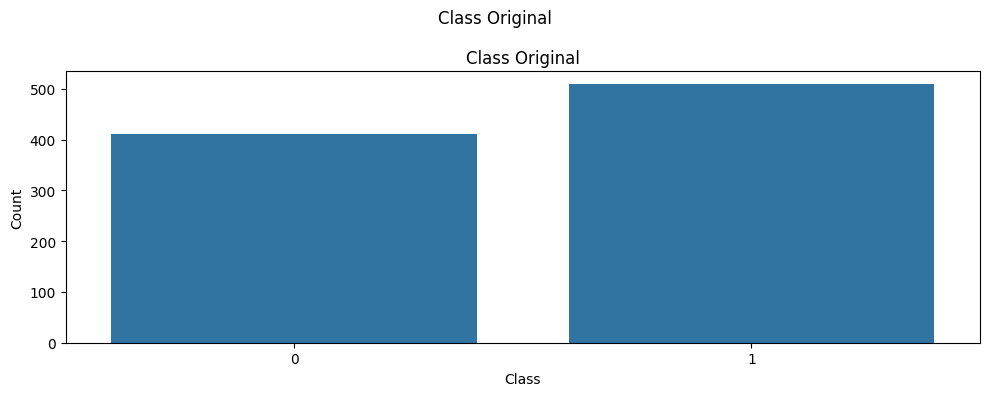

In [1]:
# %pip install numpy matplotlib seaborn graphviz

# --- Thư viện cơ bản ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import os

# --- Thư viện cho Machine Learning ---
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- Định nghĩa các đường dẫn ---
# Đi từ `notebooks` ra ngoài một cấp để thấy các thư mục khác
DATA_PATH = '../data/heart_disease.csv'
OUTPUT_IMAGE_DIR = '../outputs/heart_disease/'
# Tạo thư mục output nếu nó chưa tồn tại
os.makedirs(OUTPUT_IMAGE_DIR, exist_ok=True)

# (Tùy chọn) Thêm thư mục src vào path để import các hàm từ utils.py
import sys
sys.path.append('../')
from src.utils import plot_label_distribution, plot_label_original, build_decision_tree # Ví dụ nếu bạn có hàm riêng

from sklearn.impute import SimpleImputer

# --- Tải và khám phá dữ liệu ---
df = pd.read_csv(DATA_PATH)

# Chuyển cột 'num' thành nhãn nhị phân (0: không bệnh, 1: có bệnh)
df['num'] = (df['num'] > 0).astype(int)

# 1. Tách features và labels
features = df.drop('num', axis=1)
labels = df['num']

# 2. Áp dụng One-Hot Encoding
print("Áp dụng One-Hot Encoding...")
features_encoded = pd.get_dummies(features)
print(f"Số lượng features sau One-Hot Encoding: {features_encoded.shape[1]}")

# 3. Xử lý giá trị thiếu (NaN)
print("\nXử lý các giá trị bị thiếu...")
imputer = SimpleImputer(strategy='median')
# Dùng features_final để lưu lại kết quả cuối cùng
features_final = pd.DataFrame(imputer.fit_transform(features_encoded), columns=features_encoded.columns)

# Kiểm tra lại lần cuối để chắc chắn không còn giá trị thiếu
print("\nThông tin dữ liệu sau khi xử lý hoàn tất:")
features_final.info()

# 4. Chia dữ liệu train/test (SỬ DỤNG features_final)
print("\nChia dữ liệu thành tập train và test...")
# Danh sách tỷ lệ test để lặp
feature_train_60, feature_test_40, label_train_60, label_test_40 = train_test_split(
        features_final, labels, test_size=0.4, shuffle=True, stratify=labels, random_state=42)

feature_train_40, feature_test_60, label_train_40, label_test_60 = train_test_split(
        features_final, labels, test_size=0.6, shuffle=True, stratify=labels, random_state=42)

feature_train_80, feature_test_20, label_train_80, label_test_20 = train_test_split(
        features_final, labels, test_size=0.2, shuffle=True, stratify=labels, random_state=42)

feature_train_90, feature_test_10, label_train_90, label_test_10 = train_test_split(
        features_final, labels, test_size=0.1, shuffle=True, stratify=labels, random_state=42)

plot_label_original(labels, OUTPUT_IMAGE_DIR)

plot_label_distribution(label_train_60, label_test_40, 60, 40, OUTPUT_IMAGE_DIR)
plot_label_distribution(label_train_40, label_test_60, 40, 60, OUTPUT_IMAGE_DIR)
plot_label_distribution(label_train_80, label_test_20, 80, 20, OUTPUT_IMAGE_DIR)
plot_label_distribution(label_train_90, label_test_10, 90, 10, OUTPUT_IMAGE_DIR)


print("Hoàn tất xử lý dữ liệu!")

## 2. Building the decision tree classifiers


In [ ]:
build_decision_tree(features_final, feature_train_60, feature_test_40, label_train_60, label_test_40, 60, 40, OUTPUT_IMAGE_DIR)
build_decision_tree(features_final, feature_train_40, feature_test_60, label_train_40, label_test_60, 40, 60, OUTPUT_IMAGE_DIR)
build_decision_tree(features_final, feature_train_80, feature_test_20, label_train_80, label_test_20, 80, 20, OUTPUT_IMAGE_DIR)
build_decision_tree(features_final, feature_train_90, feature_test_10, label_train_90, label_test_10, 90, 10, OUTPUT_IMAGE_DIR)

## 3. Evaluating the decision tree classifiers


In [ ]:
# Độ sâu
depths = [None, 2, 3, 4, 5, 6, 7]
accuracies = []

output_dir = '../outputs/heart_disease/acc/'
os.makedirs(output_dir, exist_ok=True)
results = []

for depth in depths:
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=42)
    clf.fit(feature_train_80, label_train_80)
    
    y_pred = clf.predict(feature_test_20)
    acc = accuracy_score(label_test_20, y_pred)
    accuracies.append(acc)

    results.append({
        "max_depth": str(depth),
        "accuracy": acc
    })
    results_df = pd.DataFrame(results)
    print(results_df)

    # In ra bảng
    print(results_df)

    # Lưu vào CSV nếu muốn dùng trong báo cáo Word hoặc Excel
    results_df.to_csv("/heart_disease_accuracy_vs_depth.csv", index=False)

    # Vẽ và lưu cây
    dot_data = export_graphviz(clf, out_file=None, feature_names=features_final.columns, class_names=["0", "1"],
                               filled=True, rounded=True, special_characters=True)
    graph = graphviz.Source(dot_data)
    filename = f"{output_dir}tree_depth_{depth if depth else 'None'}"
    graph.render(filename=filename, format="pdf", cleanup=True)

plt.figure(figsize=(8, 5))
plt.plot([str(d) for d in depths], accuracies, marker='o')
plt.title("Accuracy theo max_depth")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.grid(True)
plt.savefig(f"{output_dir}accuracy_vs_depth.png")
plt.show()

## 4. The depth and accuracy of a decision tree
